In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

df = pd.read_csv('df_empilhado_final.csv')
df = df.drop(columns=["Unnamed: 0"])

colunas_numericas = df.columns.difference(['Nome', 'Data'])  # Exclui 'Nome' e 'Data'

# Passo 2: Remova vírgulas e converta colunas numéricas para float
for col in colunas_numericas:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)
df

,Nome,Data,EBITDA,LG,DE,GMV,ROA,ROE,FCLA,FCLF
0,3tentos,2021-07-01,119436.0,1.6,43.7,4694121.0,2.2,4.7,186785.0,-1108032.0
1,3tentos,2021-10-01,83550.0,1.7,35.8,4807768.0,3.8,7.5,-119487.0,-94868.0
2,3tentos,2022-01-01,54560.0,1.5,55.7,4887747.0,1.1,2.5,-320523.0,-409704.0
3,3tentos,2022-07-01,108988.0,1.4,44.5,5458398.0,2.9,6.5,596343.0,28224.0
4,3tentos,2022-10-01,249174.0,1.4,38.9,4632208.0,3.7,7.9,-249977.0,69746.0
...,...,...,...,...,...,...,...,...,...,...
9056,Zamp S.A.,2023-07-01,78485.0,0.4,86.6,1635318.0,-1.0,-2.9,5425.0,93351.0
9057,Zamp S.A.,2023-10-01,157194.0,0.4,80.1,1520606.0,1.4,4.3,93978.0,441774.0
9058,Zamp S.A.,2024-01-01,38715.0,0.5,136.7,921349.0,-2.0,-6.9,-59692.0,-621912.0
9059,Zamp S.A.,2024-04-01,101653.0,0.5,125.5,1016474.0,-0.6,-2.2,10855.0,172447.0


,Nome,Data,EBITDA,LG,DE,GMV,ROA,ROE,FCLA,FCLF
0,3tentos,2021-07-01,119436.0,1.6,43.7,4694121.0,2.2,4.7,186785.0,-1108032.0
1,3tentos,2021-10-01,83550.0,1.7,35.8,4807768.0,3.8,7.5,-119487.0,-94868.0
2,3tentos,2022-01-01,54560.0,1.5,55.7,4887747.0,1.1,2.5,-320523.0,-409704.0
3,3tentos,2022-07-01,108988.0,1.4,44.5,5458398.0,2.9,6.5,596343.0,28224.0
4,3tentos,2022-10-01,249174.0,1.4,38.9,4632208.0,3.7,7.9,-249977.0,69746.0
...,...,...,...,...,...,...,...,...,...,...
9056,Zamp S.A.,2023-07-01,78485.0,0.4,86.6,1635318.0,-1.0,-2.9,5425.0,93351.0
9057,Zamp S.A.,2023-10-01,157194.0,0.4,80.1,1520606.0,1.4,4.3,93978.0,441774.0
9058,Zamp S.A.,2024-01-01,38715.0,0.5,136.7,921349.0,-2.0,-6.9,-59692.0,-621912.0
9059,Zamp S.A.,2024-04-01,101653.0,0.5,125.5,1016474.0,-0.6,-2.2,10855.0,172447.0


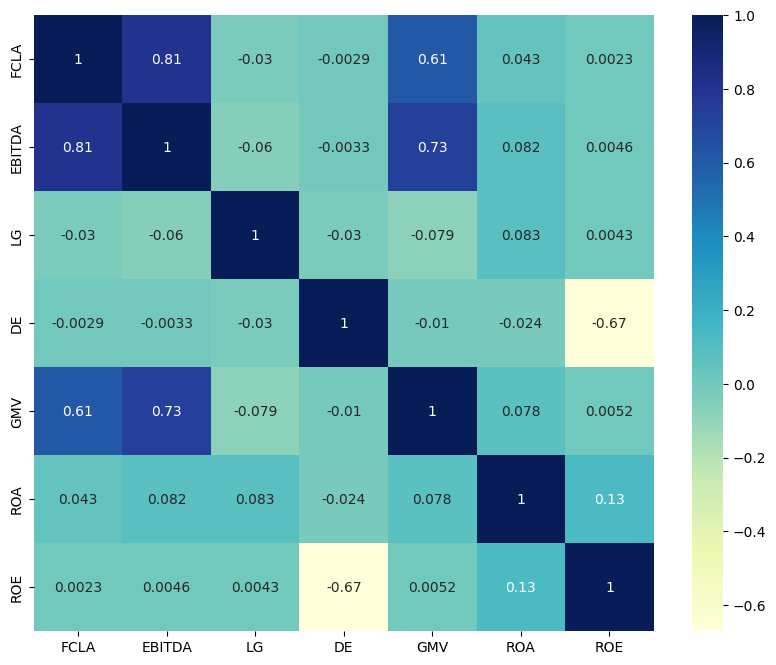

In [5]:
import seaborn as sns

features = ['FCLA', 'EBITDA', 'LG', 'DE', 'GMV', 'ROA', 'ROE']

plt.figure(figsize=(10, 8))
sns.heatmap(df[features].corr(), annot=True, cmap='YlGnBu')

df

In [6]:
df["g_FCLA"] = df.groupby("Nome")["FCLA"].pct_change()

df['g_FCLA'] = df['g_FCLA'].fillna(method='bfill')  

df_ = df[np.isfinite(df["g_FCLA"])]

if df['g_FCLA'].isnull().all():
    print("A coluna 'g' contém apenas valores ausentes.")

if df is None or df.empty:
    print("df_long não contém dados.")

df = df.dropna(subset=["g_FCLA"])
if len(df) == 0:
    print("Não há dados válidos para 'g' após o dropna.")
df

df['g_FCLA'] = df['g_FCLA'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['g_FCLA'])

df

C:\Users\carlo\AppData\Local\Temp\ipykernel_1124\3673609480.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['g_FCLA'] = df['g_FCLA'].fillna(method='bfill')


,Nome,Data,EBITDA,LG,DE,GMV,ROA,ROE,FCLA,FCLF,g_FCLA
0,3tentos,2021-07-01,119436.0,1.6,43.7,4694121.0,2.2,4.7,186785.0,-1108032.0,-1.639703
1,3tentos,2021-10-01,83550.0,1.7,35.8,4807768.0,3.8,7.5,-119487.0,-94868.0,-1.639703
2,3tentos,2022-01-01,54560.0,1.5,55.7,4887747.0,1.1,2.5,-320523.0,-409704.0,1.682493
3,3tentos,2022-07-01,108988.0,1.4,44.5,5458398.0,2.9,6.5,596343.0,28224.0,-2.860531
4,3tentos,2022-10-01,249174.0,1.4,38.9,4632208.0,3.7,7.9,-249977.0,69746.0,-1.419183
...,...,...,...,...,...,...,...,...,...,...,...
9056,Zamp S.A.,2023-07-01,78485.0,0.4,86.6,1635318.0,-1.0,-2.9,5425.0,93351.0,-1.128342
9057,Zamp S.A.,2023-10-01,157194.0,0.4,80.1,1520606.0,1.4,4.3,93978.0,441774.0,16.323134
9058,Zamp S.A.,2024-01-01,38715.0,0.5,136.7,921349.0,-2.0,-6.9,-59692.0,-621912.0,-1.635170
9059,Zamp S.A.,2024-04-01,101653.0,0.5,125.5,1016474.0,-0.6,-2.2,10855.0,172447.0,-1.181850


In [7]:
df["g_FCLF"] = df.groupby("Nome")["FCLF"].pct_change()

df['g_FCLF'] = df['g_FCLF'].fillna(method='bfill')  

df_ = df[np.isfinite(df["g_FCLF"])]

if df['g_FCLF'].isnull().all():
    print("A coluna 'g' contém apenas valores ausentes.")

if df is None or df.empty:
    print("df_long não contém dados.")

df = df.dropna(subset=["g_FCLF"])
if len(df) == 0:
    print("Não há dados válidos para 'g' após o dropna.")
df

df['g_FCLF'] = df['g_FCLF'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['g_FCLF'])

df

C:\Users\carlo\AppData\Local\Temp\ipykernel_1124\3600734392.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['g_FCLF'] = df['g_FCLF'].fillna(method='bfill')


,Nome,Data,EBITDA,LG,DE,GMV,ROA,ROE,FCLA,FCLF,g_FCLA,g_FCLF
0,3tentos,2021-07-01,119436.0,1.6,43.7,4694121.0,2.2,4.7,186785.0,-1108032.0,-1.639703,-0.914382
1,3tentos,2021-10-01,83550.0,1.7,35.8,4807768.0,3.8,7.5,-119487.0,-94868.0,-1.639703,-0.914382
2,3tentos,2022-01-01,54560.0,1.5,55.7,4887747.0,1.1,2.5,-320523.0,-409704.0,1.682493,3.318674
3,3tentos,2022-07-01,108988.0,1.4,44.5,5458398.0,2.9,6.5,596343.0,28224.0,-2.860531,-1.068889
4,3tentos,2022-10-01,249174.0,1.4,38.9,4632208.0,3.7,7.9,-249977.0,69746.0,-1.419183,1.471159
...,...,...,...,...,...,...,...,...,...,...,...,...
9056,Zamp S.A.,2023-07-01,78485.0,0.4,86.6,1635318.0,-1.0,-2.9,5425.0,93351.0,-1.128342,-2.452437
9057,Zamp S.A.,2023-10-01,157194.0,0.4,80.1,1520606.0,1.4,4.3,93978.0,441774.0,16.323134,3.732397
9058,Zamp S.A.,2024-01-01,38715.0,0.5,136.7,921349.0,-2.0,-6.9,-59692.0,-621912.0,-1.635170,-2.407761
9059,Zamp S.A.,2024-04-01,101653.0,0.5,125.5,1016474.0,-0.6,-2.2,10855.0,172447.0,-1.181850,-1.277285


In [8]:
from sklearn.preprocessing import MinMaxScaler 

features = ['FCLA', 'FCLF', 'EBITDA', 'LG', 'DE', 'GMV', 'ROA', 'ROE', 'g_FCLA', 'g_FCLF']

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df

,Nome,Data,EBITDA,LG,DE,GMV,ROA,ROE,FCLA,FCLF,g_FCLA,g_FCLF
0,3tentos,2021-07-01,0.218239,0.023634,0.203120,0.008221,0.603896,0.603701,0.361552,0.369358,0.235863,0.806436
1,3tentos,2021-10-01,0.217991,0.025111,0.203082,0.008420,0.612554,0.603771,0.358797,0.375960,0.235863,0.806436
2,3tentos,2022-01-01,0.217791,0.022157,0.203178,0.008560,0.597944,0.603646,0.356989,0.373908,0.235999,0.806567
3,3tentos,2022-07-01,0.218167,0.020679,0.203124,0.009560,0.607684,0.603746,0.365235,0.376762,0.235813,0.806431
4,3tentos,2022-10-01,0.219134,0.020679,0.203097,0.008112,0.612013,0.603782,0.357624,0.377032,0.235872,0.806510
...,...,...,...,...,...,...,...,...,...,...,...,...
9056,Zamp S.A.,2023-07-01,0.217956,0.005908,0.203327,0.002859,0.586580,0.603510,0.359921,0.377186,0.235884,0.806388
9057,Zamp S.A.,2023-10-01,0.218499,0.005908,0.203296,0.002658,0.599567,0.603691,0.360717,0.379456,0.236598,0.806579
9058,Zamp S.A.,2024-01-01,0.217682,0.007386,0.203568,0.001608,0.581169,0.603409,0.359335,0.372525,0.235863,0.806390
9059,Zamp S.A.,2024-04-01,0.218116,0.007386,0.203514,0.001775,0.588745,0.603527,0.359970,0.377701,0.235882,0.806425


In [9]:

var = ['g_FCLA']

df = df.sort_values(['Nome', 'Data'])
df['lag_g_fcla'] = df.groupby('Nome')[var].shift(1)
df['ma_g_fcla'] = df.groupby('Nome')[var].transform(lambda x: x.shift(1).rolling(3).mean())

df['lag_g_fcla'] = df['lag_g_fcla'].fillna(method='bfill')  # backward fill

df['ma_g_fcla'] = df['ma_g_fcla'].fillna(method='bfill')  # backward fill
df

C:\Users\carlo\AppData\Local\Temp\ipykernel_1124\4058139030.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['lag_g_fcla'] = df['lag_g_fcla'].fillna(method='bfill')  # backward fill
C:\Users\carlo\AppData\Local\Temp\ipykernel_1124\4058139030.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma_g_fcla'] = df['ma_g_fcla'].fillna(method='bfill')  # backward fill


,Nome,Data,EBITDA,LG,DE,GMV,ROA,ROE,FCLA,FCLF,g_FCLA,g_FCLF,lag_g_fcla,ma_g_fcla
0,3tentos,2021-07-01,0.218239,0.023634,0.203120,0.008221,0.603896,0.603701,0.361552,0.369358,0.235863,0.806436,0.235863,0.235908
1,3tentos,2021-10-01,0.217991,0.025111,0.203082,0.008420,0.612554,0.603771,0.358797,0.375960,0.235863,0.806436,0.235863,0.235908
2,3tentos,2022-01-01,0.217791,0.022157,0.203178,0.008560,0.597944,0.603646,0.356989,0.373908,0.235999,0.806567,0.235863,0.235908
3,3tentos,2022-07-01,0.218167,0.020679,0.203124,0.009560,0.607684,0.603746,0.365235,0.376762,0.235813,0.806431,0.235999,0.235908
4,3tentos,2022-10-01,0.219134,0.020679,0.203097,0.008112,0.612013,0.603782,0.357624,0.377032,0.235872,0.806510,0.235813,0.235892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9056,Zamp S.A.,2023-07-01,0.217956,0.005908,0.203327,0.002859,0.586580,0.603510,0.359921,0.377186,0.235884,0.806388,0.235912,0.235912
9057,Zamp S.A.,2023-10-01,0.218499,0.005908,0.203296,0.002658,0.599567,0.603691,0.360717,0.379456,0.236598,0.806579,0.235884,0.235881
9058,Zamp S.A.,2024-01-01,0.217682,0.007386,0.203568,0.001608,0.581169,0.603409,0.359335,0.372525,0.235863,0.806390,0.236598,0.236131
9059,Zamp S.A.,2024-04-01,0.218116,0.007386,0.203514,0.001775,0.588745,0.603527,0.359970,0.377701,0.235882,0.806425,0.235863,0.236115


In [10]:

var = ['g_FCLF']

df = df.sort_values(['Nome', 'Data'])
df['lag_g_fclf'] = df.groupby('Nome')[var].shift(1)
df['ma_g_fclf'] = df.groupby('Nome')[var].transform(lambda x: x.shift(1).rolling(3).mean())

df['lag_g_fclf'] = df['lag_g_fclf'].fillna(method='bfill')  
df['ma_g_fclf'] = df['ma_g_fclf'].fillna(method='bfill')  
df

C:\Users\carlo\AppData\Local\Temp\ipykernel_1124\3418903920.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['lag_g_fclf'] = df['lag_g_fclf'].fillna(method='bfill')
C:\Users\carlo\AppData\Local\Temp\ipykernel_1124\3418903920.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma_g_fclf'] = df['ma_g_fclf'].fillna(method='bfill')


,Nome,Data,EBITDA,LG,DE,GMV,ROA,ROE,FCLA,FCLF,g_FCLA,g_FCLF,lag_g_fcla,ma_g_fcla,lag_g_fclf,ma_g_fclf
0,3tentos,2021-07-01,0.218239,0.023634,0.203120,0.008221,0.603896,0.603701,0.361552,0.369358,0.235863,0.806436,0.235863,0.235908,0.806436,0.806479
1,3tentos,2021-10-01,0.217991,0.025111,0.203082,0.008420,0.612554,0.603771,0.358797,0.375960,0.235863,0.806436,0.235863,0.235908,0.806436,0.806479
2,3tentos,2022-01-01,0.217791,0.022157,0.203178,0.008560,0.597944,0.603646,0.356989,0.373908,0.235999,0.806567,0.235863,0.235908,0.806436,0.806479
3,3tentos,2022-07-01,0.218167,0.020679,0.203124,0.009560,0.607684,0.603746,0.365235,0.376762,0.235813,0.806431,0.235999,0.235908,0.806567,0.806479
4,3tentos,2022-10-01,0.219134,0.020679,0.203097,0.008112,0.612013,0.603782,0.357624,0.377032,0.235872,0.806510,0.235813,0.235892,0.806431,0.806478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9056,Zamp S.A.,2023-07-01,0.217956,0.005908,0.203327,0.002859,0.586580,0.603510,0.359921,0.377186,0.235884,0.806388,0.235912,0.235912,0.806481,0.806450
9057,Zamp S.A.,2023-10-01,0.218499,0.005908,0.203296,0.002658,0.599567,0.603691,0.360717,0.379456,0.236598,0.806579,0.235884,0.235881,0.806388,0.806426
9058,Zamp S.A.,2024-01-01,0.217682,0.007386,0.203568,0.001608,0.581169,0.603409,0.359335,0.372525,0.235863,0.806390,0.236598,0.236131,0.806579,0.806483
9059,Zamp S.A.,2024-04-01,0.218116,0.007386,0.203514,0.001775,0.588745,0.603527,0.359970,0.377701,0.235882,0.806425,0.235863,0.236115,0.806390,0.806452


In [11]:
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from collections import defaultdict
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

target_var = 'g_FCLF'

def expanding_window_forecast(df, target_col=target_var, empresa_col='Nome', date_col='Data',
                               min_train_size=4, horizon=1, features=['g_FCLF', 'ROE', 'LG', 'GMV', 'DE', 'lag_g_fclf', 'ma_g_fclf']):
    results = []
    feature_importances = defaultdict(list)

    for empresa_id, grupo in df.groupby(empresa_col):
        grupo = grupo.sort_values(date_col).reset_index(drop=True)
        
        for end_train in range(min_train_size, len(grupo) - horizon + 1):
            train = grupo.iloc[:end_train]
            test = grupo.iloc[end_train:end_train + horizon]

            X_train = train[features]
            y_train = train[target_col]
            X_test = test[features]
            y_test = test[target_col]

            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                tree_method='hist',
                n_estimators=300,
                max_depth=2,
                learning_rate=0.05,
                subsample=0.7,
                colsample_bytree=0.8,
                n_jobs=-1,
                verbosity=0,
                reg_alpha=1,
                reg_lambda=10
            )
            
            assert not y_train.isna().any(), "y_train contém NaN"
            assert not np.isinf(y_train).any(), "y_train contém infinito"

            model.fit(X_train, y_train)

            # Coleta de importância das features
            for feature, importance in zip(features, model.feature_importances_):
                feature_importances[feature].append(importance)

            y_pred = model.predict(X_test)
            erro = abs(y_pred[0] - y_test.values[0])
            y_train_pred = model.predict(X_train)
            train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
            test_rmse = mean_squared_error(y_test, y_pred, squared=False)

            overfitting = train_rmse < test_rmse * 0.5
            underfitting = train_rmse > test_rmse * 0.5  

            results.append({
                'Empresa': empresa_id,
                'Data': test[date_col].values[0],
                'Real': y_test.values[0],
                'Previsto': y_pred[0],
                'Erro Absoluto': erro,
                'Train RMSE': train_rmse,
                'Test RMSE': test_rmse,
                'Overfitting?': overfitting,
                'Underfitting?': underfitting
            })

    # Média das importâncias
    avg_importances = {feature: np.mean(vals) for feature, vals in feature_importances.items()}
    importancias_df = pd.DataFrame(list(avg_importances.items()), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

    return pd.DataFrame(results), importancias_df

media = df[target_var].mean()
dp = df[target_var].std()

start = time.time()
resultado, importancias = expanding_window_forecast(df)
end = time.time()


print(f'Tempo de computação: {end - start:.2f} segundos')

rmse = mean_squared_error(resultado['Real'], resultado['Previsto'], squared=False)
mae = mean_absolute_error(resultado['Real'], resultado['Previsto'])
r2 = r2_score(resultado['Real'], resultado['Previsto'])

n = len(resultado)  
p = len(['g_FCLF', 'ROE', 'LG', 'GMV', 'DE', 'lag_g_fclf', 'ma_g_fclf'])  
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

train_rmse_media = resultado['Train RMSE'].mean()
test_rmse_media = resultado['Test RMSE'].mean()
print(f'R2 da regressão: {r2}')
print(f'R2 ajustado da regressão: {r2_adj}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RMSE como % da média: {(rmse/media)*100:.2f}%')
print(f'RMSE como % do DP: {(rmse/dp)*100:.2f}%')
print(f'RMSE Treino Média: {train_rmse_media}')
print(f'RMSE Teste Média: {test_rmse_media}')
print(f'Fit do modelo: {train_rmse_media/test_rmse_media}')

resultado

Tempo de computação: 278.63 segundos
R2 da regressão: -0.0835835525016333
RMSE: 0.010985310951401508
MAE: 0.0006497033660804955
RMSE como % da média: 1.36%
RMSE como % do DP: 109.77%
RMSE Treino Média: 0.000996458854740269
RMSE Teste Média: 0.0006497033660804955
Fit do modelo: 1.5337135480021693


,Empresa,Data,Real,Previsto,Erro Absoluto,Train RMSE,Test RMSE,Overfitting?,Underfitting?
0,3tentos,2022-10-01,0.806510,0.806467,0.000042,0.000057,0.000042,False,True
1,3tentos,2023-01-01,0.806410,0.806476,0.000065,0.000054,0.000065,False,True
2,3tentos,2023-04-01,0.806508,0.806465,0.000043,0.000055,0.000043,False,True
3,3tentos,2023-07-01,0.806415,0.806471,0.000056,0.000053,0.000056,False,True
4,3tentos,2023-10-01,0.806359,0.806464,0.000105,0.000053,0.000105,False,True
...,...,...,...,...,...,...,...,...,...
7921,Zamp S.A.,2023-07-01,0.806388,0.806402,0.000014,0.000402,0.000014,False,True
7922,Zamp S.A.,2023-10-01,0.806579,0.806401,0.000178,0.000393,0.000178,False,True
7923,Zamp S.A.,2024-01-01,0.806390,0.806408,0.000019,0.000387,0.000019,False,True
7924,Zamp S.A.,2024-04-01,0.806425,0.806408,0.000017,0.000379,0.000017,False,True


In [12]:
resultado.to_csv('XGBoost_resultados_FCLF.csv')

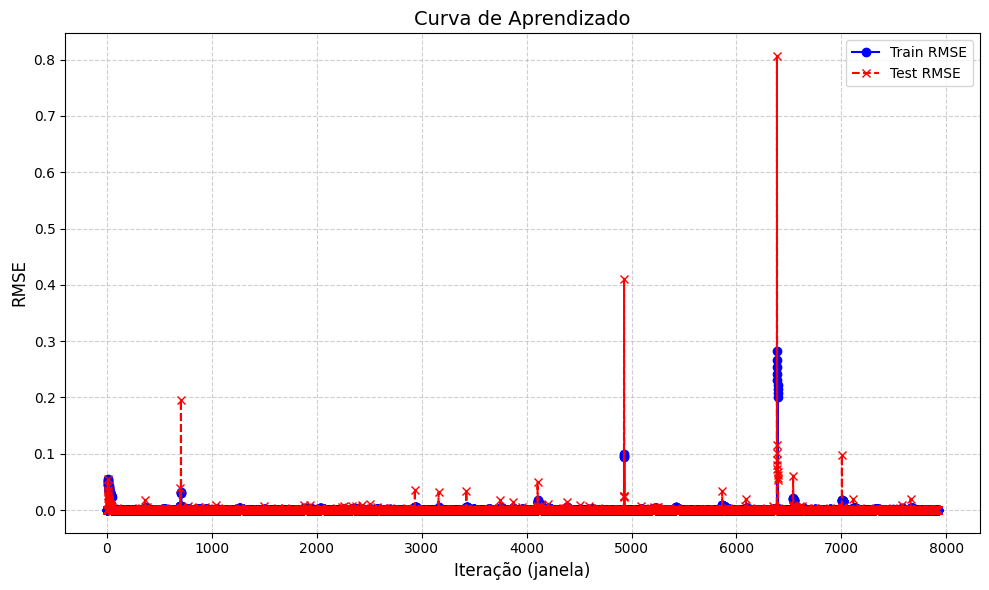

In [13]:
x_vals = range(len(resultado))  # ou resultado['Data'] se quiser por data

plt.figure(figsize=(10, 6))
plt.plot(x_vals, resultado['Train RMSE'], label='Train RMSE', marker='o', linestyle='-', color='blue')
plt.plot(x_vals, resultado['Test RMSE'], label='Test RMSE', marker='x', linestyle='--', color='red')
plt.title('Curva de Aprendizado', fontsize=14)
plt.xlabel('Iteração (janela)', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

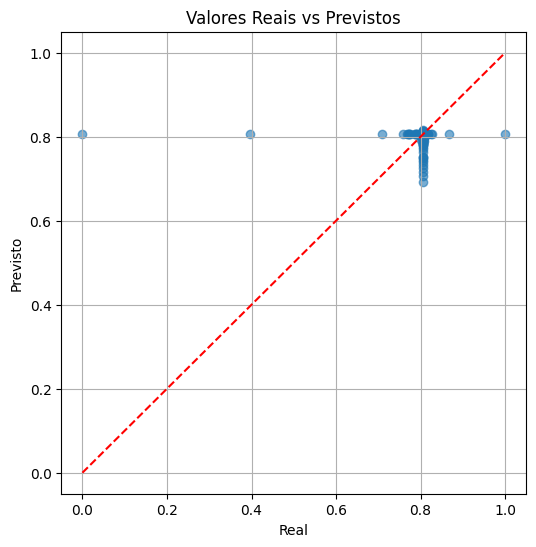

In [14]:
plt.figure(figsize=(6, 6))
plt.scatter(resultado['Real'], resultado['Previsto'], alpha=0.6)
plt.plot([resultado['Real'].min(), resultado['Real'].max()],
         [resultado['Real'].min(), resultado['Real'].max()],
         color='red', linestyle='--')
plt.xlabel('Real')
plt.ylabel('Previsto')
plt.title('Valores Reais vs Previstos')
plt.grid(True)
plt.show()

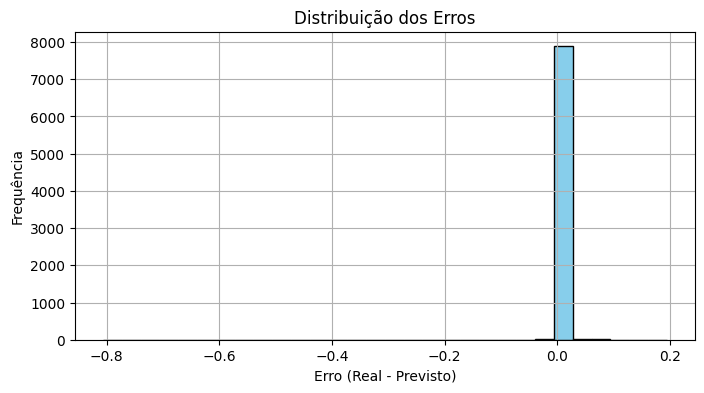

In [15]:
resultado['Erro'] = resultado['Real'] - resultado['Previsto']

plt.figure(figsize=(8, 4))
plt.hist(resultado['Erro'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição dos Erros')
plt.xlabel('Erro (Real - Previsto)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

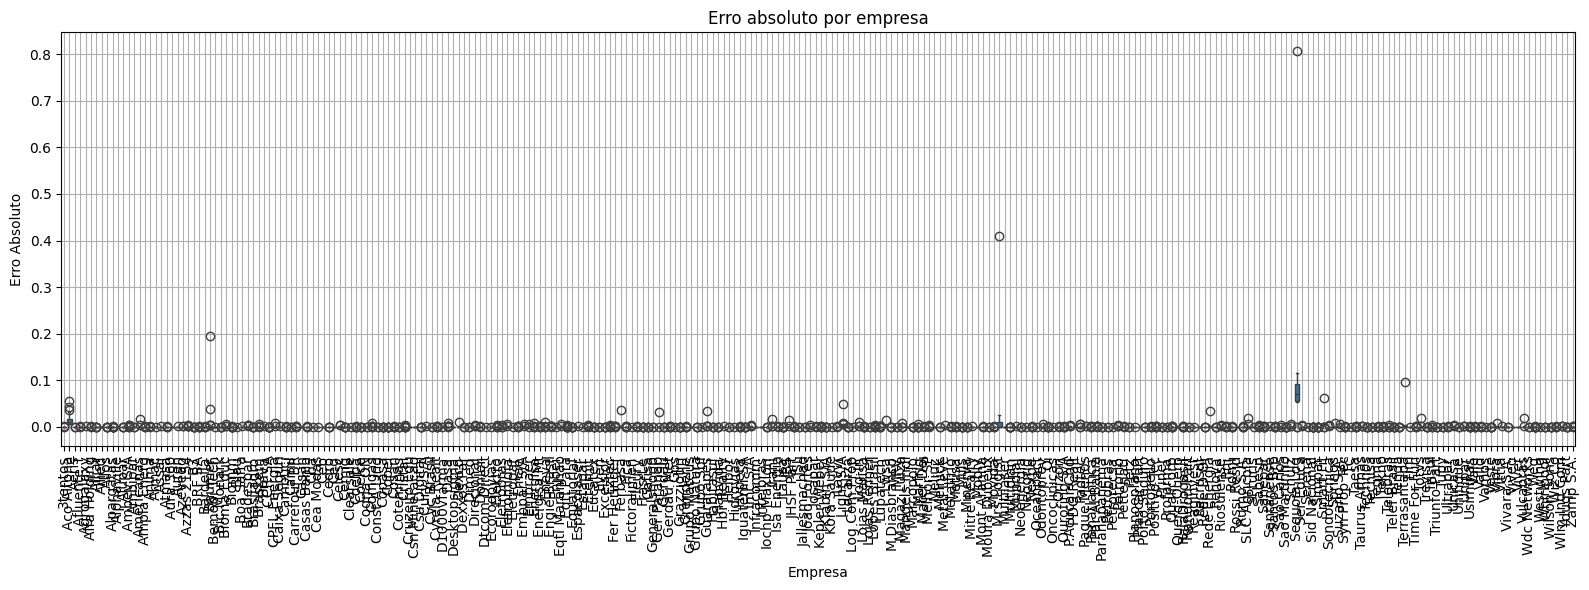

In [16]:
plt.figure(figsize=(16,6))
sns.boxplot(data=resultado, x='Empresa', y='Erro Absoluto')
plt.xticks(rotation=90)
plt.title('Erro absoluto por empresa')
plt.grid(True)
plt.tight_layout()
plt.show()

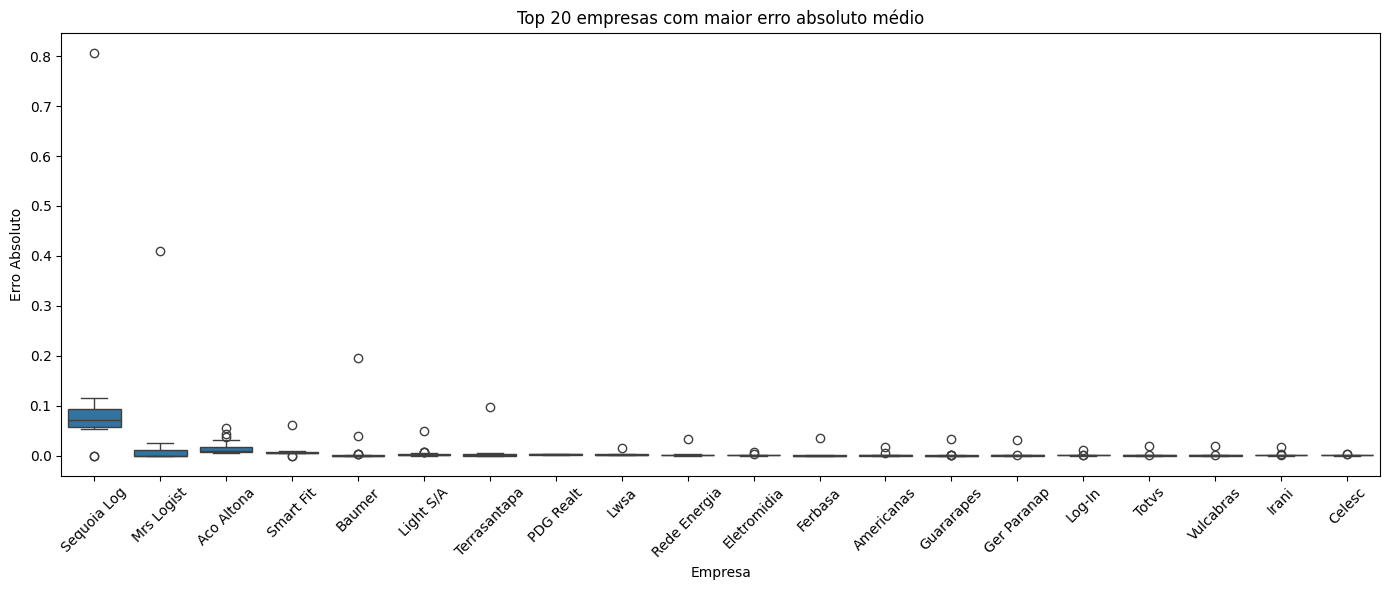

In [17]:
top_n = 20
top_empresas = resultado.groupby('Empresa')['Erro Absoluto'].mean().nlargest(top_n).index

plt.figure(figsize=(14, 6))
sns.boxplot(data=resultado[resultado['Empresa'].isin(top_empresas)],
            x='Empresa', y='Erro Absoluto', order=top_empresas)
plt.xticks(rotation=45)
plt.title(f'Top {top_n} empresas com maior erro absoluto médio')
plt.tight_layout()
plt.show()


Importância média das features:
      Feature  Importance
0      g_FCLF         0.0
1         ROE         0.0
2          LG         0.0
3         GMV         0.0
4          DE         0.0
5  lag_g_fclf         0.0
6   ma_g_fclf         0.0


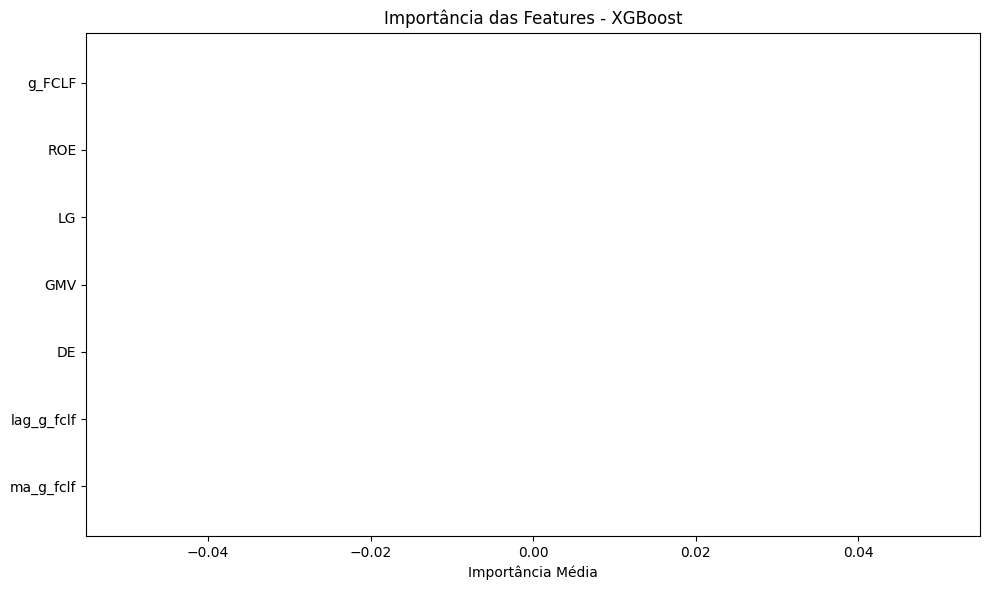

In [18]:
# Importância das features
print("\nImportância média das features:")
print(importancias)

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(importancias['Feature'], importancias['Importance'], color='skyblue')
plt.xlabel('Importância Média')
plt.title('Importância das Features - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

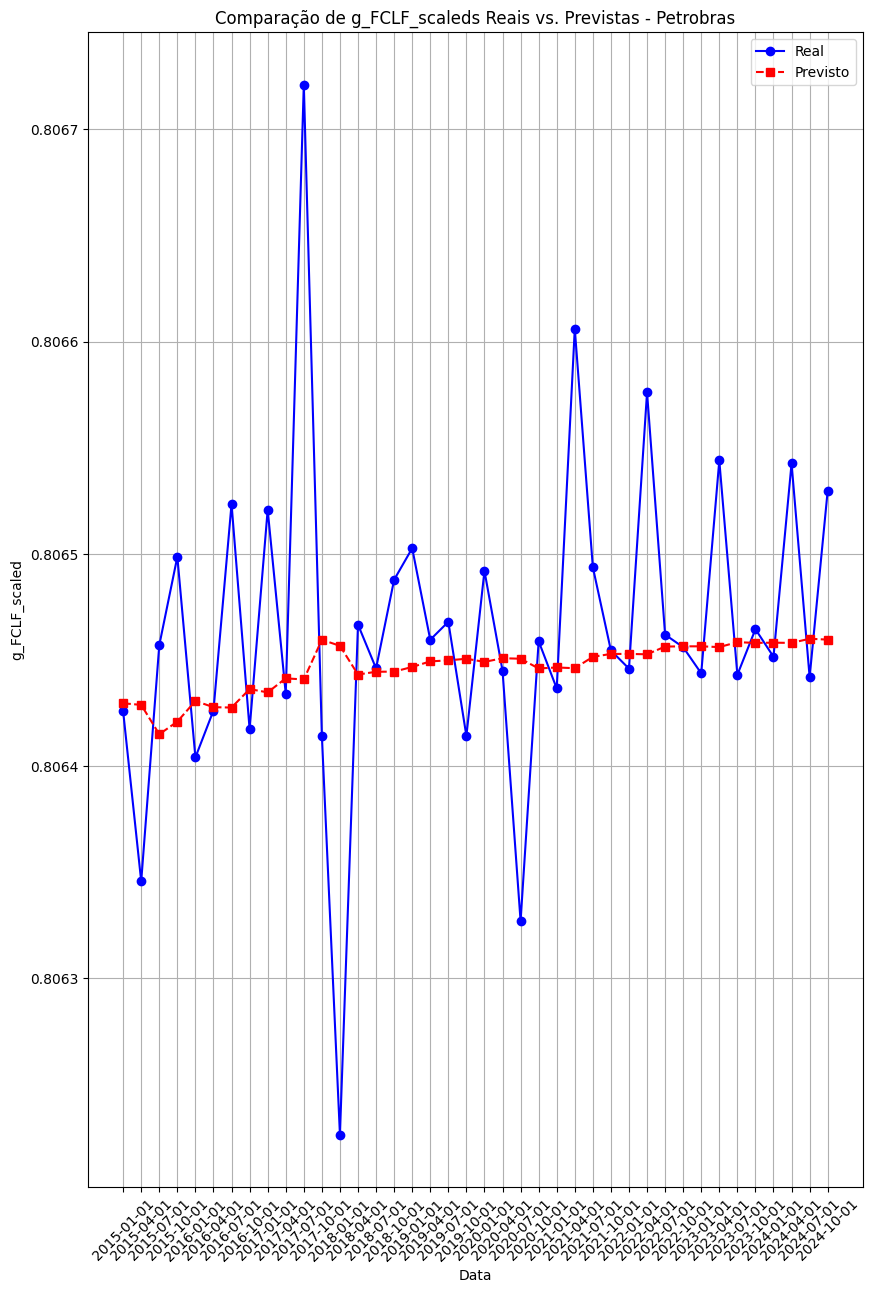

In [20]:
results_df = resultado
empresa_selecionada = 'Petrobras'
df_selecionado = results_df[results_df["Empresa"] == empresa_selecionada]

plt.figure(figsize=(10,15))
plt.plot(df_selecionado["Data"], df_selecionado["Real"], label="Real", marker='o', linestyle='solid', color="blue")
plt.plot(df_selecionado["Data"], df_selecionado["Previsto"], label="Previsto", marker='s', linestyle='dashed', color="red")

plt.xlabel("Data")
plt.ylabel("g_FCLF_scaled")
plt.title(f"Comparação de g_FCLF_scaleds Reais vs. Previstas - {empresa_selecionada}")
plt.legend()
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X para melhor visualização
plt.grid(True)

plt.show()